In [2]:
# Your code here - remember to use markdown cells for comments as well!
import os
import re
import math
import json

import pandas as pd
import numpy as np

from scipy import stats, linalg

from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error


import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# set style
sns.set_style('whitegrid')
# overriding font size and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# map visualization
import folium

# don't print matching warnings
import warnings
warnings.filterwarnings('ignore') 



In [3]:
# read data and read date correctly
kc_df = pd.read_csv("kc_house_data.csv", parse_dates = ['date'])

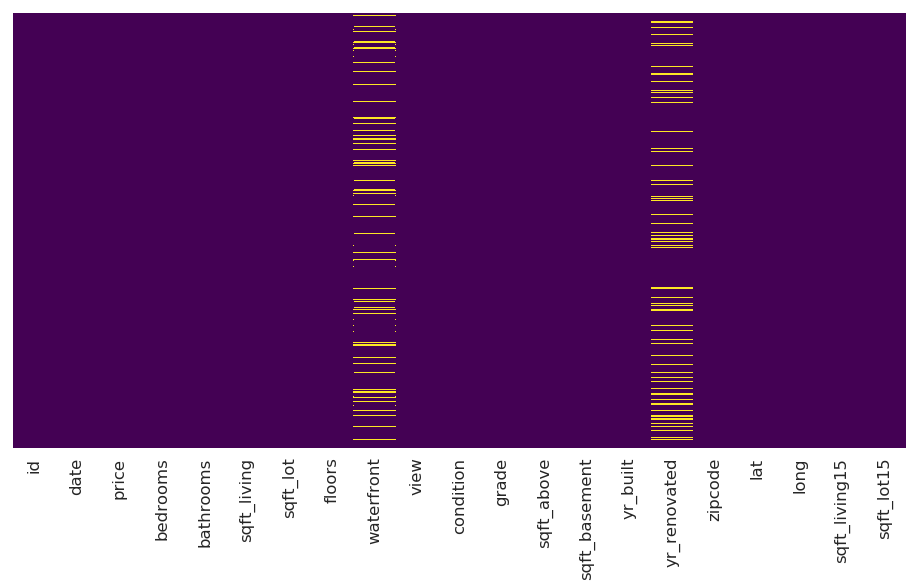

In [24]:
fig = plt.figure(figsize=(16, 8))
sns.heatmap(kc_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

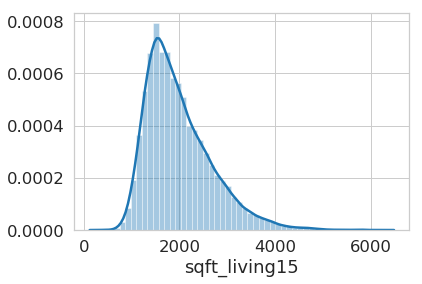

In [22]:
sns.distplot(kc_df.sqft_living15, bins=50, kde=True, label='sqft_living15')

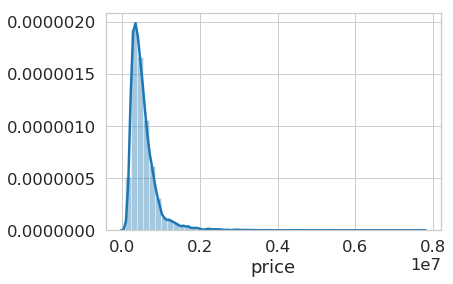

In [21]:
sns.distplot(kc_df.price, bins=50, kde=True, label='price')

In [ ]:

kc_df['yr_built'] = pd.to_datetime(kc_df['yr_built'])
kc_df['yr_built'] = kc_df['yr_built'].dt.year
kc_df.head()
# kc_df['yr_renovated'] = pd.to_datetime(kc_df['yr_renovated']).dt.year

In [ ]:
kc_df.shape

In [ ]:
# get the mean value across all data points
zipcode_data = kc_df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)
zipcode_data = zipcode_data[['zipcode']]

In [ ]:
temp = kc_df.groupby('zipcode', as_index=False)['price'].aggregate(np.mean)
temp.price = np.floor(temp.price)
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')

In [ ]:
temp = kc_df.groupby('zipcode', as_index=False)['sqft_living15'].aggregate(np.mean)
temp.sqft_living15 = np.floor(temp.sqft_living15)
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')

In [ ]:
# count number of entries grouped by zipcode
kc_df['count'] = 1

temp_df = kc_df.groupby('zipcode').sum()
temp_df.reset_index(inplace = True)
temp_df = temp_df[['zipcode', 'count']]

kc_df.drop(['count'], axis = 1, inplace = True)

zipcode_data = pd.merge(zipcode_data, temp_df, on='zipcode')

In [ ]:
zipcode_data.head(2)

In [ ]:
del temp_df

In [ ]:
kc_df['yr_built'] = pd.to_datetime(kc_df['yr_built']).dt.year
# kc_df['yr_renovated'] = pd.to_datetime(kc_df['yr_renovated']).dt.year

kc_df.head()

In [ ]:
kc_df['count'] = 1
kc_df.groupby('zipcode').sum()



In [ ]:
# total = kc_df.isnull().sum().sort_values(ascending=False)

# calc percent of total null values

# missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head()

In [ ]:
kc_df.dtypes

In [ ]:
kc_df.head()

In [ ]:
kc_df.shape

In [ ]:
# Display all missing data
msno.matrix(kc_df)

In [4]:
# Set zipcode type to string
kc_df['zipcode'] = kc_df['zipcode'].astype('str')

# Convert sqft_basement to int
kc_df['sqft_basement'] = pd.to_numeric(kc_df['sqft_basement'], errors='coerce')

# set category and order them
kc_df['grade'] = kc_df['grade'].astype('category', ordered = False)
# data['waterfront'] = data['waterfront'].astype('category', ordered = True)
kc_df['condition'] = kc_df['condition'].astype('category', ordered = True)

# Drop columns which are not in the offical dataset (kaggle) and might mess up our stuff
# data.drop(columns=['sqft_living15', 'sqft_lot15'], inplace=True)

# sort data by date
kc_df = kc_df.sort_values(by = ['date'])

In [5]:
# get the mean value across all data points
zipcode_data = kc_df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)

# count number of entries grouped by zipcode
kc_df['count'] = 1

temp_df = kc_df.groupby('zipcode').sum()
temp_df.reset_index(inplace = True)
temp_df = temp_df[['zipcode', 'count']]

# kc_df.drop(['count'], axis = 1, inplace = True)

# merge the count values into the zipcode data
zipcode_data = pd.merge(zipcode_data, temp_df, how='left', on=['zipcode'])
zipcode_data.head(2)

,zipcode,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,count
0,98001,4.651274e+09,281194.869806,3.393352,2.011773,1903.783934,14967.002770,1.430748,0.0,0.094708,1723.756233,184.107649,1980.867036,28.038732,47.309106,-122.270704,1830.099723,11218.875346,361
1,98002,4.850894e+09,234284.035176,3.326633,1.839196,1627.743719,7517.633166,1.334171,0.0,0.010050,1522.537688,105.737374,1967.773869,60.212121,47.308780,-122.213357,1479.030151,7585.482412,199


In [6]:
# Get geo data file path
geo_data_file = os.path.join('data', 'king_county_wa_zipcode_area.geojson')

# load GeoJSON
with open(geo_data_file, 'r') as jsonFile:
    geo_data = json.load(jsonFile)
    
tmp = geo_data

# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save uodated JSON object
open("cleaned_geodata.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

11783863

In [ ]:
def show_zipcode_map(col):
    # read updated geo data
    king_geo = "cleaned_geodata.json"
    
    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[47.35, -121.9], zoom_start=9, 
        detect_retina = True, control_scale=False)

    # Create choropleth map
    m.choropleth(
        geo_data = king_geo,
        name = 'choropleth',
        data = zipcode_data,
        # col: feature of interest
        columns = ['zipcode', 'count'], 
        key_on = 'feature.properties.ZIPCODE',
        fill_color = 'OrRd', 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        legend_name = 'count'
    )

    folium.LayerControl().add_to(m)
    # Save map based on feature of interest
    m.save(col + '.html')
    
    return m
    
show_zipcode_map('count')

In [ ]:
data = kc_df.copy()
data.drop(['id', 'date'], axis=1, inplace=True)

In [ ]:
scaler = preprocessing.RobustScaler()
robust_scaled_df = scaler.fit_transform(data)
robust_scaled_df = pd.DataFrame(robust_scaled_df)

In [ ]:
import statsmodels.api as sms

X = data.sqft_living15
X = sms.add_constant(X)
y = data.price

model = sms.OLS(y, X).fit()
model.summary()

In [ ]:
kc_df['zipcode'].unique()

In [ ]:
cols = ['price', 'sqft_living15', 'sqft_lot15', 'count', 'yr_built', 'zipcode']
sns.pairplot(kc_df[cols], hue = 'price', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

In [14]:
lat = np.array(kc_df.lat, dtype=pd.Series)
lon = np.array(kc_df.long, dtype=pd.Series)
mag = np.array(kc_df.price, dtype=pd.Series)/10000000

d = np.dstack((lat, lon, mag))[0]
heatmap_data = [i for i in d.tolist()]

In [20]:
import pandas as pd 
import folium
from folium.plugins import HeatMap

hmap = folium.Map(location=[47.55, -122.0], zoom_start=10, tiles='stamentoner')

hm_wide = HeatMap( heatmap_data,
                   min_opacity=0.7,
                   max_val=mg.max(),
                   radius=2, blur=2, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

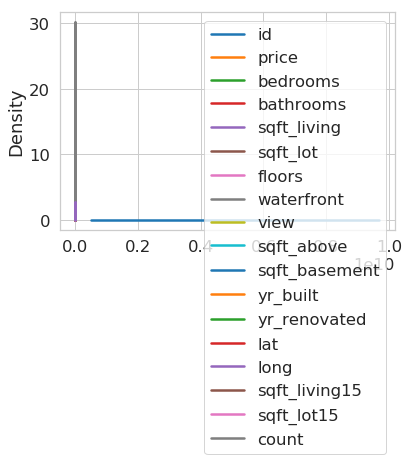

In [18]:
kc_df.plot.kde()